In [69]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
# import necessary libraries
import ee
import geemap

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [70]:
# Forecasts
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_forecasts_2024.geojson')

In [71]:
random_color = lambda: np.random.random(3)

In [72]:
# look at the forecasts
day1_forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2023-08-02 08:00:00,70,1,POINT (-69.75497 37.90491)
1,1,24,2023-08-02 20:00:00,75,1,POINT (-70.50738 38.86856)
2,1,36,2023-08-03 08:00:00,85,2,POINT (-71.35866 39.41313)
3,1,48,2023-08-03 20:00:00,85,2,POINT (-71.72152 40.51758)
4,1,60,2023-08-04 08:00:00,100,3,POINT (-71.48969 41.18486)
...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (-71.49297 40.27587)
156,20,60,2023-08-04 08:00:00,100,3,POINT (-70.95934 42.12895)
157,20,72,2023-08-04 20:00:00,105,3,POINT (-71.61717 40.70945)
158,20,96,2023-08-05 20:00:00,90,2,POINT (-70.44554 43.65152)


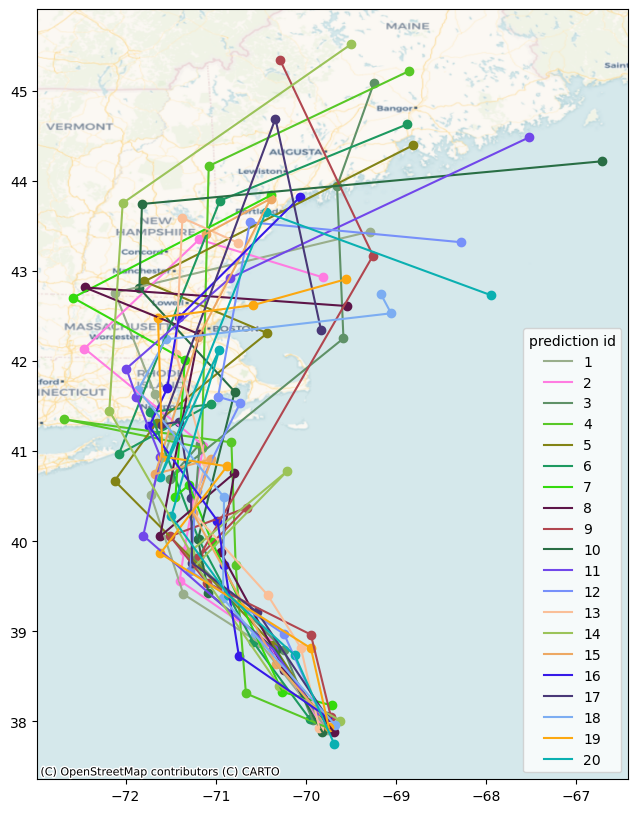

In [73]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in day1_forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')
ctx.add_basemap(ax,
               crs=day1_forecast.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [74]:
#put it in meters
day1_forecast_utm = (day1_forecast
                     .to_crs(day1_forecast.estimate_utm_crs())
                    )

day1_forecast_utm["x"] = day1_forecast_utm.geometry.x
day1_forecast_utm["y"] = day1_forecast_utm.geometry.y

day1_forecast_utm


,prediction,forecastHour,datetime,maxWinds,category,geometry,x,y
0,1,12,2023-08-02 08:00:00,70,1,POINT (433629.56 4195533.402),433629.559834,4.195533e+06
1,1,24,2023-08-02 20:00:00,75,1,POINT (369229.136 4303270.796),369229.136006,4.303271e+06
2,1,36,2023-08-03 08:00:00,85,2,POINT (296941.056 4365278.025),296941.055799,4.365278e+06
3,1,48,2023-08-03 20:00:00,85,2,POINT (269441.75 4488764.971),269441.749791,4.488765e+06
4,1,60,2023-08-04 08:00:00,100,3,POINT (291190.307 4562266.885),291190.307229,4.562267e+06
...,...,...,...,...,...,...,...,...
155,20,48,2023-08-03 20:00:00,85,2,POINT (288048.889 4461358.998),288048.889383,4.461359e+06
156,20,60,2023-08-04 08:00:00,100,3,POINT (338056.994 4665951.053),338056.994238,4.665951e+06
157,20,72,2023-08-04 20:00:00,105,3,POINT (278917.064 4509798.311),278917.063668,4.509798e+06
158,20,96,2023-08-05 20:00:00,90,2,POINT (383428.653 4834184.482),383428.653251,4.834184e+06


In [75]:
#centroids
day1_forecast_centroid_utm = (day1_forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=day1_forecast_utm.crs ))
    )


day1_forecast_centroid_utm

,forecastHour,x,y,geometry
0,12,431013.171246,4.205562e+06,POINT (431013.171 4205562.358)
1,24,383776.795557,4.291724e+06,POINT (383776.796 4291723.649)
2,36,316221.478205,4.399308e+06,POINT (316221.478 4399307.608)
3,48,311348.742931,4.496668e+06,POINT (311348.743 4496668.321)
4,60,297292.489615,4.551259e+06,POINT (297292.49 4551258.648)
5,72,297655.503997,4.625268e+06,POINT (297655.504 4625267.632)
6,96,337862.155698,4.801626e+06,POINT (337862.156 4801626.092)
7,120,477607.910696,4.851970e+06,POINT (477607.911 4851970.224)


In [76]:
day1_forecasthr12 = day1_forecast.loc[day1_forecast['forecastHour']==12]
day1_forecasthr24 = day1_forecast.loc[day1_forecast['forecastHour']==24]
day1_forecasthr36 = day1_forecast.loc[day1_forecast['forecastHour']==36]
day1_forecasthr48 = day1_forecast.loc[day1_forecast['forecastHour']==48]
day1_forecasthr60 = day1_forecast.loc[day1_forecast['forecastHour']==60]
day1_forecasthr72 = day1_forecast.loc[day1_forecast['forecastHour']==72]
day1_forecasthr96 = day1_forecast.loc[day1_forecast['forecastHour']==96]
day1_forecasthr120 = day1_forecast.loc[day1_forecast['forecastHour']==120]

In [77]:
#distances between points and centroids
dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

#dist_gdf


In [78]:
radii = dist_gdf.groupby("forecastHour", as_index=False)[["dist_m"]].mean()
#radii

In [79]:
#.pipe switches the grouped dataframe to a geodataframe
day1_forecast_dist_m_utm = (day1_forecast_centroid_utm.merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
#day1_forecast_dist_m_utm

In [80]:
day1_forecast_circle  = day1_forecast_dist_m_utm
day1_forecast_circle['geometry'] = day1_forecast_circle.geometry.buffer(day1_forecast_circle.dist_m)
#day1_forecast_circle

In [141]:
day1_forecast_circle_partial = day1_forecast_circle.iloc[:6,:]

day1_forecast_circle_total = day1_forecast_circle.iloc[:,:]


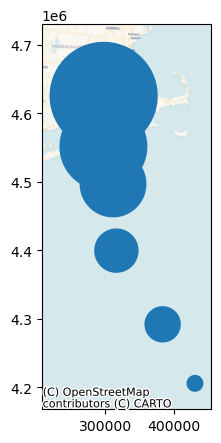

In [142]:
# partial cone graphed 
fig, ax = plt.subplots(1, 1, figsize=(5,5))

day1_forecast_circle_partial.plot(ax=ax)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

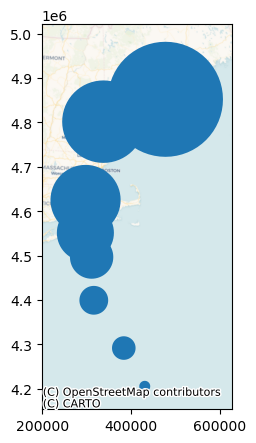

In [143]:
# full  cone graphed 
fig, ax = plt.subplots(1, 1, figsize=(5,5))

day1_forecast_circle_total.plot(ax=ax)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [144]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

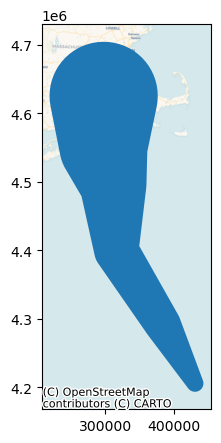

In [145]:
cone_partial = visualizeUncertainty(day1_forecast_circle_partial)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

p = gpd.GeoSeries(cone_partial)
p.plot(ax=ax)


ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()
# partial cone


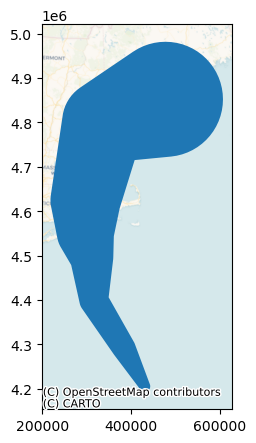

In [146]:
cone_full = visualizeUncertainty(day1_forecast_circle_total)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

p = gpd.GeoSeries(cone)
p.plot(ax=ax)


ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()
# total cone


In [121]:
ee.Initialize()
#  population density dataset
pop_dataset = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").first()
pop_raster = pop_dataset.select("population_count")

# Define visualization parameters with a new color palette
viz = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]
}

# Create an interactive map
Map = geemap.Map(center=[42.407, -71.384], zoom=5)
Map.addLayer(pop_raster, viz, "Population Density")

# Display the map
Map

Map(center=[42.407, -71.384], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [130]:
ee.Initialize()
import shapely.geometry
from pyproj import Transformer

# Assuming the UTM zone is 33N. Replace '33N' with the appropriate UTM zone for your data.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Reproject the UTM polygon to WGS84.
cone2 = shapely.ops.transform(transformer.transform, cone_partial)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone2)

# Load the GeoJSON into GEE as a feature.
cone_GEE = ee.Feature(geojson)


In [131]:
# Remove misclassified pixels in areas with slopes greater than 5%
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')

In [132]:
cone_GEE2 = cone_GEE.getInfo()['geometry']

# Import JRC Global Human Settlement Popluation Density layer (250m) - number of people per cell
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015').clip(cone_GEE2)

# Create a raster showing exposed population only using the resampled flood layer
population_exposed = population_count

# Sum pixel values of exposed population raster
stats = population_exposed.reduceRegion(reducer= ee.Reducer.sum(),
                                        geometry= cone_GEE2,
                                        scale= 250,
                                        maxPixels=1e9)

# Get number of exposed people as integer
number_pop_exposed = stats.getNumber('population_count').round()
print(f'Calculation result --> Estimated Exposed population from Hurricane X(FROM PARTIAL CONE FIRST 6HRS):\n{number_pop_exposed.getInfo()}')

Calculation result --> Estimated Exposed population from Hurricane X(FROM PARTIAL CONE FIRST 6HRS):
5353787


In [ ]:
# full cone population 

In [135]:
ee.Initialize()
import shapely.geometry
from pyproj import Transformer

# Assuming the UTM zone is 33N. Replace '33N' with the appropriate UTM zone for your data.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Reproject the UTM polygon to WGS84.
cone_full1 = shapely.ops.transform(transformer.transform, cone_full)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone_full1)

# Load the GeoJSON into GEE as a feature.
cone_GEE3 = ee.Feature(geojson)

cone_GEE4 = cone_GEE3.getInfo()['geometry']

# Import JRC Global Human Settlement Popluation Density layer (250m) - number of people per cell
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015').clip(cone_GEE4)

# Create a raster showing exposed population only using the resampled flood layer
population_exposed = population_count#.updateMask(inundation3).updateMask(population_count)

# Sum pixel values of exposed population raster
stats = population_exposed.reduceRegion(reducer= ee.Reducer.sum(),
                                        geometry= cone_GEE4,
                                        scale= 250,
                                        maxPixels=1e9)

# Get number of exposed people as integer
number_pop_exposed = stats.getNumber('population_count').round()
print(f'Calculation result --> Estimated Exposed population from Hurricane X FROM TOTAL CONE:\n{number_pop_exposed.getInfo()}')

Calculation result --> Estimated Exposed population from Hurricane X FROM TOTAL CONE:
9472077


In [ ]:
# MAP OF SVI IN THE STATES

Original profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 13353, 'height': 6297, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333330000749, 0.0, -178.23333334,
       0.0, -0.00833333329998412, 71.383332688), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
Updated profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 13353, 'height': 6297, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00833333330000749, 0.0, -178.23333334,
       0.0, -0.00833333329998412, 71.383332688), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


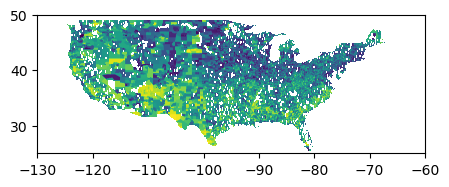

In [89]:
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt

SVI_tile = 'svi_2020_tract_overall_wgs84.tif'

def resize_tile(tile_location, rescaling_factor):
    with rasterio.open(tile_location) as src:
        print(f'Original profile: {src.profile}')
        
        new_height = int(src.height * rescaling_factor)  
        new_width = int(src.width * rescaling_factor)
        
        tile = src.read(1, out_shape=(new_height, new_width), 
                        resampling=rasterio.enums.Resampling.bilinear)
        
        tile_profile = src.profile.copy()  
        tile_profile['transform'] = src.transform * src.transform.scale(
            (src.width / tile.shape[-1]),
            (src.height / tile.shape[-2])
        )
        tile_profile['height'] = new_height
        tile_profile['width'] = new_width
        
        print(f'Updated profile: {tile_profile}')
        return tile, tile_profile

rescaling_factor = 1  

tile1, tile1_profile = resize_tile(SVI_tile, rescaling_factor)

tile1_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
    outfile.write(tile1, 1)  # Write the data to the new file

with rasterio.open(lowres_tile1_loc) as src:
    tile1_mask = src.read_masks(1)  # Read the mask
    tile1 = src.read(1)  # Read the resized image

fig = plt.figure(figsize=[5, 5])
ax1 = fig.add_subplot(2, 1, 1)
rasterio.plot.show(np.ma.masked_where(tile1_mask == 0, tile1), ax=ax1, transform=tile1_profile['transform'])
ax1.set_xlim(-130,-60 )
ax1.set_ylim(25,50)

plt.show()


In [137]:
# DAY 1 EVAUCATION NUMBERS 
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015')

# ----------------------SLOPE-----------------------------------------
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')


vis_params = {
    'min': -25,      
    'max': 700   
}

slope_vis = {
    'min': 0,          
    'max': 30,        
    'palette': "GnBu"  
}
viz_svi = {
    "min": 0.0,  
    "max": 1.0,  
    "palette": ['blue', 'green', 'yellow', 'purple']  
}

#  mask for slopes less than 5%
slope_mask = slope.lt(5)

#  SVI data
svi = ee.Image('projects/geometric-edge-428819-k5/assets/svi_2020_tract_overall_wgs84')

# -----------SVI is a numerical value from 0 to 1 , higher values towards 1 indicates a higher vr
svi_threshold = 0.5  

#SVI mask for less than theshold 
svi_mask = svi.gt(svi_threshold)

#  slope mask + SVI mask
combined_mask = slope_mask.And(svi_mask)

population_clipped = population_count.clip(cone_GEE.geometry())

population_masked = population_clipped.updateMask(combined_mask)

stats = population_masked.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=cone_GEE.geometry(),
    scale=250,  
    maxPixels=1e9
)

number_pop_inside_cone = stats.getNumber('population_count').round()

print(f'Calculation result --> Estimated population inside the cone with slopes less than 5% and SVI below(PARTIAL CONE POP #s) {svi_threshold}:\n{number_pop_inside_cone.getInfo()}')



Calculation result --> Estimated population inside the cone with slopes less than 5% and SVI below(PARTIAL CONE POP #s) 0.5:
1638907


In [138]:
# DAY 1 EVAUCATION NUMBERS 
population_count = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015')

# ----------------------SLOPE-----------------------------------------
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')


vis_params = {
    'min': -25,      
    'max': 700   
}

slope_vis = {
    'min': 0,          
    'max': 30,        
    'palette': "GnBu"  
}
viz_svi = {
    "min": 0.0,  
    "max": 1.0,  
    "palette": ['blue', 'green', 'yellow', 'purple']  
}

#  mask for slopes less than 5%
slope_mask = slope.lt(5)

#  SVI data
svi = ee.Image('projects/geometric-edge-428819-k5/assets/svi_2020_tract_overall_wgs84')

# -----------SVI is a numerical value from 0 to 1 , higher values towards 1 indicates a higher vr
svi_threshold = 0.5  

#SVI mask for less than theshold 
svi_mask = svi.gt(svi_threshold)

#  slope mask + SVI mask
combined_mask = slope_mask.And(svi_mask)

population_clipped = population_count.clip(cone_GEE3.geometry())

population_masked = population_clipped.updateMask(combined_mask)

stats = population_masked.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=cone_GEE3.geometry(),
    scale=250,  
    maxPixels=1e9
)

number_pop_inside_cone = stats.getNumber('population_count').round()

print(f'Calculation result --> Estimated population inside the cone with slopes less than 5% and SVI below(FULL CONE POP #s) {svi_threshold}:\n{number_pop_inside_cone.getInfo()}')



Calculation result --> Estimated population inside the cone with slopes less than 5% and SVI below(PARTIAL CONE POP #s) 0.5:
2632315


In [139]:
import ee
import shapely.geometry
import shapely.ops
from pyproj import Transformer
import geopandas as gpd
import geemap

# Initialize the Earth Engine API
ee.Initialize()

# Assuming the UTM zone is 19N. Replace '26919' with the appropriate EPSG code for your UTM zone.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Assuming `cone` is defined elsewhere in your code
# Reproject the UTM polygon to WGS84.
cone2 = shapely.ops.transform(transformer.transform, cone)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone2)

# Load the GeoJSON into GEE as a Geometry
cone_GEE_geometry = ee.Geometry(geojson)

# Remove misclassified pixels in areas with slopes greater than 5%
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')

# Retrieve the coastline from FAO/GAUL data, filtering for the United States
coastline = (ee.FeatureCollection("FAO/GAUL/2015/level0")
             .filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))
             .filterBounds(cone_GEE_geometry))

# Convert the coastline FeatureCollection to GeoJSON and save it
geemap.ee_to_geojson(coastline, 'coastline.geojson')

# Load the GeoJSON file into a GeoPandas GeoDataFrame
clip_region = gpd.read_file('coastline.geojson')

# Define visualization parameters
vis_params = {
    'min': -25,
    'max': 700
}

slope_vis = {
    'min': 0,
    'max': 30,
    'palette': "GnBu"
}

# Create a map to visualize the results
Map = geemap.Map(center=[30.3753, -82.9796], zoom=10)
Map.addLayer(srtm, vis_params, 'SRTM')
Map.addLayer(slope, slope_vis, 'Slope')
Map.addLayer(cone_GEE.geometry(), {'color': 'black'}, 'Cone Geometry')
Map.addLayer(population_masked, {'palette': 'red'}, 'Population Exposed')
Map.addLayer(svi, viz_svi, 'SVI')
Map.addLayer(coastline, {}, 'Coastline')
Map.centerObject(cone_GEE, 5)


# Display the map
Map

Map(center=[40.65396823011885, -71.15131317312112], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# total cone map with various other layers 

In [149]:
import ee
import shapely.geometry
import shapely.ops
from pyproj import Transformer
import geopandas as gpd
import geemap

# Initialize the Earth Engine API
ee.Initialize()

# Assuming the UTM zone is 19N. Replace '26919' with the appropriate EPSG code for your UTM zone.
transformer = Transformer.from_crs("epsg:26919", "epsg:4326", always_xy=True)

# Assuming `cone` is defined elsewhere in your code
# Reproject the UTM polygon to WGS84.
cone2 = shapely.ops.transform(transformer.transform, cone)

# Convert Shapely polygon to GeoJSON format.
geojson = shapely.geometry.mapping(cone2)

# Load the GeoJSON into GEE as a Geometry
cone_GEE3_geometry = ee.Geometry(geojson)

# Remove misclassified pixels in areas with slopes greater than 5%
srtm = ee.Image('USGS/SRTMGL1_003')
terrain = ee.Algorithms.Terrain(srtm)
slope = terrain.select('slope')

# Retrieve the coastline from FAO/GAUL data, filtering for the United States
coastline = (ee.FeatureCollection("FAO/GAUL/2015/level0")
             .filter(ee.Filter.eq('ADM0_NAME', 'United States of America'))
             .filterBounds(cone_GEE3_geometry))

# Convert the coastline FeatureCollection to GeoJSON and save it
geemap.ee_to_geojson(coastline, 'coastline.geojson')

# Load the GeoJSON file into a GeoPandas GeoDataFrame
clip_region = gpd.read_file('coastline.geojson')

# Define visualization parameters
vis_params = {
    'min': -25,
    'max': 700
}

slope_vis = {
    'min': 0,
    'max': 30,
    'palette': "GnBu"
}

# Create a map to visualize the results
Map = geemap.Map(center=[30.3753, -82.9796], zoom=10)
Map.addLayer(srtm, vis_params, 'SRTM')
Map.addLayer(slope, slope_vis, 'Slope')
Map.addLayer(cone_GEE3.geometry(), {'color': 'black'}, 'Cone Geometry')
Map.addLayer(population_masked, {'palette': 'red'}, 'Population Exposed')
Map.addLayer(svi, viz_svi, 'SVI')
Map.addLayer(coastline, {}, 'Coastline')
Map.centerObject(cone_GEE3, 5)


# Display the map
Map

Map(center=[42.502515145340915, -70.41160098898091], controls=(WidgetControl(options=['position', 'transparent…

# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson')
day1_track.plot()

# Location of Areas of Interest
